In [1]:
from edgedroid.models import *
import edgedroid.data as e_data
from gabriel_lego import LEGOTask, FrameResult
from tqdm.notebook import tqdm

model = EdgeDroidModel(
    frame_trace=e_data.load_default_trace("square00", truncate=5),
    frame_model=ZeroWaitSamplingPolicy.from_default_data(),
    timing_model=MultiCurveFittingExecutionTimeModel(neuroticism=1.0)
)

task = LEGOTask(e_data.load_default_task("square00", truncate=5))


def generate_latencies(mode: float, rho: float, min_bound: float = 0.0) -> Iterator[float]:
    prev_value = mode
    while True:
        prev_value = np.random.rayleigh(scale=(mode * (1 - rho)) + (prev_value * rho))
        yield min_bound + prev_value


def emulate_run(model: EdgeDroidModel, task: LEGOTask, rtt_s_iter: Iterator[float], desc: str | None = None):
    step_iter = tqdm(model.play_steps_emulated_time(), total=model.step_count + 1, desc=desc, leave=False)
    
    for model_step in step_iter:
        frame_timings: Optional[FrameTimings] = None
        prev_result: Optional[FrameResult] = None
        while True:
            try:
                model_frame = model_step.send(frame_timings)
            except StopIteration:
                if prev_result != FrameResult.SUCCESS:
                    raise Exception(prev_result)
                break
            prev_result = task.submit_frame(model_frame.frame_data)
            
            rtt = next(rtt_s_iter)
            frame_timings = FrameTimings(rtt * 0.9, rtt * 0.1)
            

emulate_run(model, task, generate_latencies(3.2, rho=.2, min_bound=0.1))
model.model_step_metrics()

  0%|          | 0/6 [00:00<?, ?it/s]

,last_frame_rtt,execution_time,step_duration,time_to_feedback,wait_time,frame_count
step_number,,,,,,
0,1.147508,0.000000,1.147508,1.147508,0.000000,1
1,3.015083,5.262081,14.582644,9.320563,6.305481,3
2,5.133374,6.628337,12.204204,5.575868,0.442494,3
3,1.380976,6.628337,9.443050,2.814714,1.433738,3
4,2.182885,5.542658,7.967498,2.424840,0.241955,3
5,6.211184,5.447864,13.328542,7.880678,1.669494,3


In [2]:
import itertools as it

trace = "square00"
truncate = 50
reps_per_model = 10

timing_models = {
    "curve-high": lambda : MultiCurveFittingExecutionTimeModel(neuroticism=1.0),
    "curve-low": lambda : MultiCurveFittingExecutionTimeModel(neuroticism=0.0),
    "legacy": lambda : LegacyModel(),
    "first-order": lambda : FirstOrderETM(),
    "first-order-median": lambda : FirstOrderAggregateETM(np.median)
}

min_bound = 0.042 # 24FPS
rho_vals = (
    # 0.0, 
    # 0.25, 
    # 0.5
    0.6,
    0.7,
    0.8,
)
sigma_vals = (
    0.1, 
    0.2, 
    0.4, 
    0.8, 
    1.6, 
    3.2
)

dfs = deque()

params_iter = tqdm(list(it.product(
    timing_models.items(),
    range(reps_per_model),
    rho_vals,
    sigma_vals
)), desc="Parameter combinations")
for (model_name, model_constructor), rep, rho, sigma in params_iter:
    model = EdgeDroidModel(
        frame_trace=e_data.load_default_trace(trace, truncate=truncate),
        frame_model=ZeroWaitSamplingPolicy.from_default_data(),
        timing_model=model_constructor()
    )

    task = LEGOTask(e_data.load_default_task(trace, truncate=truncate))
    
    desc = f"{model_name} {rho=} {sigma=} ({rep + 1}/{reps_per_model})"
    emulate_run(model, task, generate_latencies(sigma, rho, min_bound=min_bound), desc=desc)
    
    df = model.model_step_metrics()
    df["model"] = model_name
    df["rep"] = rep
    df["rho"] = rho
    df["sigma"] = sigma
    
    dfs.append(df)
    
data = pd.concat(dfs)
data.to_csv("./per_frame_delay_high_corr.csv")
data

Parameter combinations:   0%|          | 0/900 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.1 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.2 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.4 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.8 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=1.6 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=3.2 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.1 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.2 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.4 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.8 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=1.6 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=3.2 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.1 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.2 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.4 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.8 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=1.6 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=3.2 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.1 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.2 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.4 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.8 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=1.6 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=3.2 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.1 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.2 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.4 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.8 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=1.6 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=3.2 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.1 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.2 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.4 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.8 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=1.6 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=3.2 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.1 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.2 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.4 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.8 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=1.6 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=3.2 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.1 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.2 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.4 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.8 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=1.6 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=3.2 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.1 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.2 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.4 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.8 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=1.6 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=3.2 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.1 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.2 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.4 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.8 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=1.6 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=3.2 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.1 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.2 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.4 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.8 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=1.6 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=3.2 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.1 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.2 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.4 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.8 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=1.6 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=3.2 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.1 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.2 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.4 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.8 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=1.6 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=3.2 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.1 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.2 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.4 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.8 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=1.6 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=3.2 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.1 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.2 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.4 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.8 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=1.6 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=3.2 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.1 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.2 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.4 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.8 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=1.6 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=3.2 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.1 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.2 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.4 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.8 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=1.6 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=3.2 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.1 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.2 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.4 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.8 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=1.6 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=3.2 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.1 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.2 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.4 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.8 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=1.6 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=3.2 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.1 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.2 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.4 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.8 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=1.6 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=3.2 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.1 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.2 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.4 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.8 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=1.6 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=3.2 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.1 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.2 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.4 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.8 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=1.6 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=3.2 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.1 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.2 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.4 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.8 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=1.6 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=3.2 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.1 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.2 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.4 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.8 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=1.6 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=3.2 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.1 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.2 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.4 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.8 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=1.6 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=3.2 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.1 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.2 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.4 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.8 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=1.6 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=3.2 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.1 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.2 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.4 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.8 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=1.6 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=3.2 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.1 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.2 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.4 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=0.8 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=1.6 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.6 sigma=3.2 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.1 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.2 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.4 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=0.8 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=1.6 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.7 sigma=3.2 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.1 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.2 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.4 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=0.8 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=1.6 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-high rho=0.8 sigma=3.2 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.1 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.2 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.4 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.8 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=1.6 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=3.2 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.1 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.2 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.4 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.8 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=1.6 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=3.2 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.1 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.2 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.4 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.8 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=1.6 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=3.2 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.1 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.2 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.4 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.8 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=1.6 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=3.2 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.1 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.2 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.4 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.8 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=1.6 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=3.2 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.1 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.2 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.4 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.8 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=1.6 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=3.2 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.1 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.2 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.4 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.8 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=1.6 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=3.2 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.1 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.2 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.4 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.8 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=1.6 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=3.2 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.1 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.2 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.4 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.8 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=1.6 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=3.2 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.1 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.2 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.4 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.8 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=1.6 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=3.2 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.1 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.2 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.4 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.8 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=1.6 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=3.2 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.1 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.2 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.4 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.8 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=1.6 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=3.2 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.1 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.2 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.4 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.8 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=1.6 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=3.2 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.1 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.2 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.4 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.8 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=1.6 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=3.2 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.1 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.2 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.4 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.8 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=1.6 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=3.2 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.1 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.2 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.4 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.8 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=1.6 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=3.2 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.1 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.2 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.4 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.8 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=1.6 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=3.2 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.1 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.2 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.4 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.8 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=1.6 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=3.2 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.1 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.2 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.4 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.8 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=1.6 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=3.2 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.1 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.2 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.4 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.8 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=1.6 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=3.2 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.1 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.2 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.4 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.8 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=1.6 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=3.2 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.1 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.2 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.4 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.8 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=1.6 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=3.2 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.1 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.2 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.4 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.8 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=1.6 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=3.2 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.1 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.2 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.4 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.8 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=1.6 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=3.2 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.1 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.2 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.4 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.8 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=1.6 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=3.2 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.1 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.2 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.4 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.8 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=1.6 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=3.2 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.1 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.2 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.4 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.8 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=1.6 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=3.2 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.1 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.2 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.4 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=0.8 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=1.6 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.6 sigma=3.2 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.1 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.2 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.4 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=0.8 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=1.6 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.7 sigma=3.2 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.1 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.2 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.4 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=0.8 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=1.6 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

curve-low rho=0.8 sigma=3.2 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.1 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.2 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.4 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.8 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=1.6 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=3.2 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.1 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.2 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.4 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.8 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=1.6 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=3.2 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.1 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.2 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.4 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.8 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=1.6 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=3.2 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.1 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.2 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.4 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.8 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=1.6 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=3.2 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.1 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.2 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.4 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.8 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=1.6 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=3.2 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.1 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.2 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.4 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.8 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=1.6 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=3.2 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.1 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.2 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.4 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.8 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=1.6 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=3.2 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.1 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.2 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.4 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.8 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=1.6 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=3.2 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.1 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.2 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.4 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.8 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=1.6 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=3.2 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.1 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.2 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.4 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.8 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=1.6 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=3.2 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.1 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.2 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.4 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.8 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=1.6 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=3.2 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.1 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.2 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.4 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.8 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=1.6 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=3.2 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.1 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.2 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.4 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.8 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=1.6 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=3.2 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.1 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.2 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.4 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.8 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=1.6 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=3.2 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.1 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.2 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.4 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.8 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=1.6 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=3.2 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.1 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.2 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.4 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.8 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=1.6 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=3.2 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.1 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.2 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.4 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.8 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=1.6 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=3.2 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.1 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.2 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.4 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.8 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=1.6 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=3.2 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.1 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.2 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.4 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.8 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=1.6 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=3.2 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.1 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.2 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.4 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.8 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=1.6 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=3.2 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.1 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.2 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.4 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.8 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=1.6 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=3.2 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.1 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.2 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.4 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.8 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=1.6 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=3.2 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.1 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.2 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.4 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.8 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=1.6 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=3.2 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.1 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.2 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.4 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.8 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=1.6 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=3.2 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.1 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.2 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.4 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.8 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=1.6 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=3.2 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.1 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.2 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.4 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.8 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=1.6 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=3.2 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.1 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.2 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.4 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.8 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=1.6 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=3.2 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.1 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.2 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.4 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=0.8 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=1.6 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.6 sigma=3.2 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.1 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.2 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.4 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=0.8 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=1.6 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.7 sigma=3.2 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.1 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.2 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.4 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=0.8 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=1.6 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

legacy rho=0.8 sigma=3.2 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.1 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.2 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.4 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.8 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=1.6 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=3.2 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.1 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.2 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.4 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.8 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=1.6 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=3.2 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.1 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.2 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.4 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.8 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=1.6 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=3.2 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.1 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.2 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.4 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.8 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=1.6 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=3.2 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.1 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.2 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.4 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.8 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=1.6 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=3.2 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.1 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.2 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.4 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.8 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=1.6 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=3.2 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.1 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.2 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.4 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.8 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=1.6 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=3.2 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.1 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.2 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.4 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.8 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=1.6 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=3.2 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.1 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.2 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.4 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.8 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=1.6 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=3.2 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.1 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.2 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.4 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.8 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=1.6 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=3.2 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.1 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.2 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.4 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.8 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=1.6 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=3.2 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.1 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.2 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.4 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.8 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=1.6 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=3.2 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.1 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.2 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.4 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.8 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=1.6 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=3.2 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.1 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.2 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.4 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.8 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=1.6 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=3.2 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.1 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.2 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.4 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.8 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=1.6 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=3.2 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.1 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.2 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.4 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.8 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=1.6 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=3.2 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.1 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.2 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.4 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.8 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=1.6 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=3.2 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.1 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.2 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.4 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.8 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=1.6 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=3.2 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.1 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.2 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.4 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.8 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=1.6 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=3.2 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.1 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.2 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.4 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.8 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=1.6 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=3.2 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.1 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.2 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.4 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.8 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=1.6 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=3.2 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.1 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.2 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.4 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.8 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=1.6 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=3.2 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.1 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.2 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.4 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.8 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=1.6 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=3.2 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.1 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.2 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.4 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.8 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=1.6 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=3.2 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.1 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.2 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.4 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.8 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=1.6 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=3.2 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.1 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.2 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.4 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.8 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=1.6 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=3.2 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.1 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.2 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.4 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.8 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=1.6 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=3.2 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.1 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.2 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.4 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=0.8 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=1.6 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.6 sigma=3.2 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.1 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.2 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.4 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=0.8 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=1.6 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.7 sigma=3.2 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.1 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.2 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.4 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=0.8 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=1.6 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order rho=0.8 sigma=3.2 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.1 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.2 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.4 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.8 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=1.6 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=3.2 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.1 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.2 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.4 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.8 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=1.6 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=3.2 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.1 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.2 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.4 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.8 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=1.6 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=3.2 (1/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.1 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.2 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.4 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.8 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=1.6 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=3.2 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.1 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.2 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.4 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.8 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=1.6 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=3.2 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.1 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.2 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.4 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.8 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=1.6 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=3.2 (2/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.1 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.2 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.4 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.8 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=1.6 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=3.2 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.1 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.2 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.4 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.8 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=1.6 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=3.2 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.1 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.2 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.4 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.8 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=1.6 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=3.2 (3/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.1 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.2 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.4 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.8 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=1.6 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=3.2 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.1 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.2 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.4 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.8 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=1.6 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=3.2 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.1 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.2 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.4 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.8 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=1.6 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=3.2 (4/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.1 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.2 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.4 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.8 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=1.6 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=3.2 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.1 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.2 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.4 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.8 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=1.6 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=3.2 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.1 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.2 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.4 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.8 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=1.6 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=3.2 (5/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.1 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.2 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.4 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.8 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=1.6 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=3.2 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.1 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.2 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.4 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.8 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=1.6 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=3.2 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.1 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.2 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.4 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.8 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=1.6 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=3.2 (6/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.1 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.2 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.4 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.8 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=1.6 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=3.2 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.1 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.2 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.4 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.8 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=1.6 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=3.2 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.1 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.2 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.4 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.8 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=1.6 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=3.2 (7/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.1 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.2 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.4 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.8 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=1.6 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=3.2 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.1 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.2 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.4 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.8 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=1.6 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=3.2 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.1 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.2 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.4 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.8 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=1.6 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=3.2 (8/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.1 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.2 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.4 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.8 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=1.6 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=3.2 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.1 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.2 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.4 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.8 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=1.6 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=3.2 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.1 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.2 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.4 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.8 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=1.6 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=3.2 (9/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.1 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.2 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.4 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=0.8 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=1.6 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.6 sigma=3.2 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.1 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.2 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.4 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=0.8 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=1.6 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.7 sigma=3.2 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.1 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.2 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.4 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=0.8 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=1.6 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

first-order-median rho=0.8 sigma=3.2 (10/10):   0%|          | 0/51 [00:00<?, ?it/s]

,last_frame_rtt,execution_time,step_duration,time_to_feedback,wait_time,frame_count,model,rep,rho,sigma
step_number,,,,,,,,,,
0,0.117627,0.000000,0.117627,0.117627,0.000000,1,curve-high,0,0.6,0.1
1,0.227455,4.994081,5.331210,0.337129,0.109674,32,curve-high,0,0.6,0.1
2,0.092071,5.074968,5.238291,0.163323,0.071252,31,curve-high,0,0.6,0.1
3,0.791030,5.012295,5.873063,0.860768,0.069737,15,curve-high,0,0.6,0.1
4,0.329382,5.211453,5.736224,0.524771,0.195389,32,curve-high,0,0.6,0.1
...,...,...,...,...,...,...,...,...,...,...
46,25.360626,5.230947,48.026907,42.795960,17.435334,2,first-order-median,9,0.8,3.2
47,38.420309,5.230947,59.062582,53.831635,15.411326,2,first-order-median,9,0.8,3.2
48,20.647725,5.230947,35.464616,30.233669,9.585943,2,first-order-median,9,0.8,3.2


,model,rep,rho,sigma,step_duration
0,curve-high,0,0.0,0.1,213.669584
1,curve-high,0,0.0,0.2,235.053415
2,curve-high,0,0.0,0.4,303.845079
3,curve-high,0,0.0,0.8,356.731061
4,curve-high,0,0.0,1.6,474.719026
...,...,...,...,...,...
895,legacy,9,0.5,0.2,236.459827
896,legacy,9,0.5,0.4,272.205988
897,legacy,9,0.5,0.8,317.271544
898,legacy,9,0.5,1.6,463.070794


In [42]:
data = pd.read_csv("./per_frame_delay.csv")
models = pd.CategoricalDtype(["curve-low", "curve-high", "legacy", "first-order", "first-order-median"], ordered=False)
data["model"] = data["model"].astype(models)
data["rho"] = data["rho"].astype("category")
data["sigma"] = data["sigma"].astype("category")
data

,step_number,last_frame_rtt,execution_time,step_duration,time_to_feedback,wait_time,frame_count,model,rep,rho,sigma
0,0,0.143041,0.000000,0.143041,0.143041,0.000000,1,curve-high,0,0.0,0.1
1,1,0.201519,5.004304,5.333957,0.329653,0.128135,33,curve-high,0,0.0,0.1
2,2,0.143975,5.072477,5.222050,0.149573,0.005599,32,curve-high,0,0.0,0.1
3,3,0.067107,5.006894,5.083496,0.076602,0.009495,27,curve-high,0,0.0,0.1
4,4,0.140907,4.585061,4.731451,0.146390,0.005483,33,curve-high,0,0.0,0.1
...,...,...,...,...,...,...,...,...,...,...,...
45895,46,13.235569,5.230947,19.331939,14.100992,0.865423,2,first-order-median,9,0.5,3.2
45896,47,3.071064,5.230947,8.727258,3.496311,0.425247,4,first-order-median,9,0.5,3.2
45897,48,4.797235,5.230947,10.105197,4.874250,0.077015,3,first-order-median,9,0.5,3.2
45898,49,5.621127,5.230947,14.359866,9.128919,3.507792,4,first-order-median,9,0.5,3.2


In [43]:
total_durations = data.groupby(["model", "rep", "rho", "sigma"])["step_duration"].sum().reset_index()
total_durations

/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_78371/2967254643.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_durations = data.groupby(["model", "rep", "rho", "sigma"])["step_duration"].sum().reset_index()


,model,rep,rho,sigma,step_duration
0,curve-low,0,0.0,0.1,194.621116
1,curve-low,0,0.0,0.2,236.042004
2,curve-low,0,0.0,0.4,293.955499
3,curve-low,0,0.0,0.8,341.913779
4,curve-low,0,0.0,1.6,454.097454
...,...,...,...,...,...
895,first-order-median,9,0.5,0.2,302.529278
896,first-order-median,9,0.5,0.4,331.709799
897,first-order-median,9,0.5,0.8,400.792286
898,first-order-median,9,0.5,1.6,526.262302


mean duration


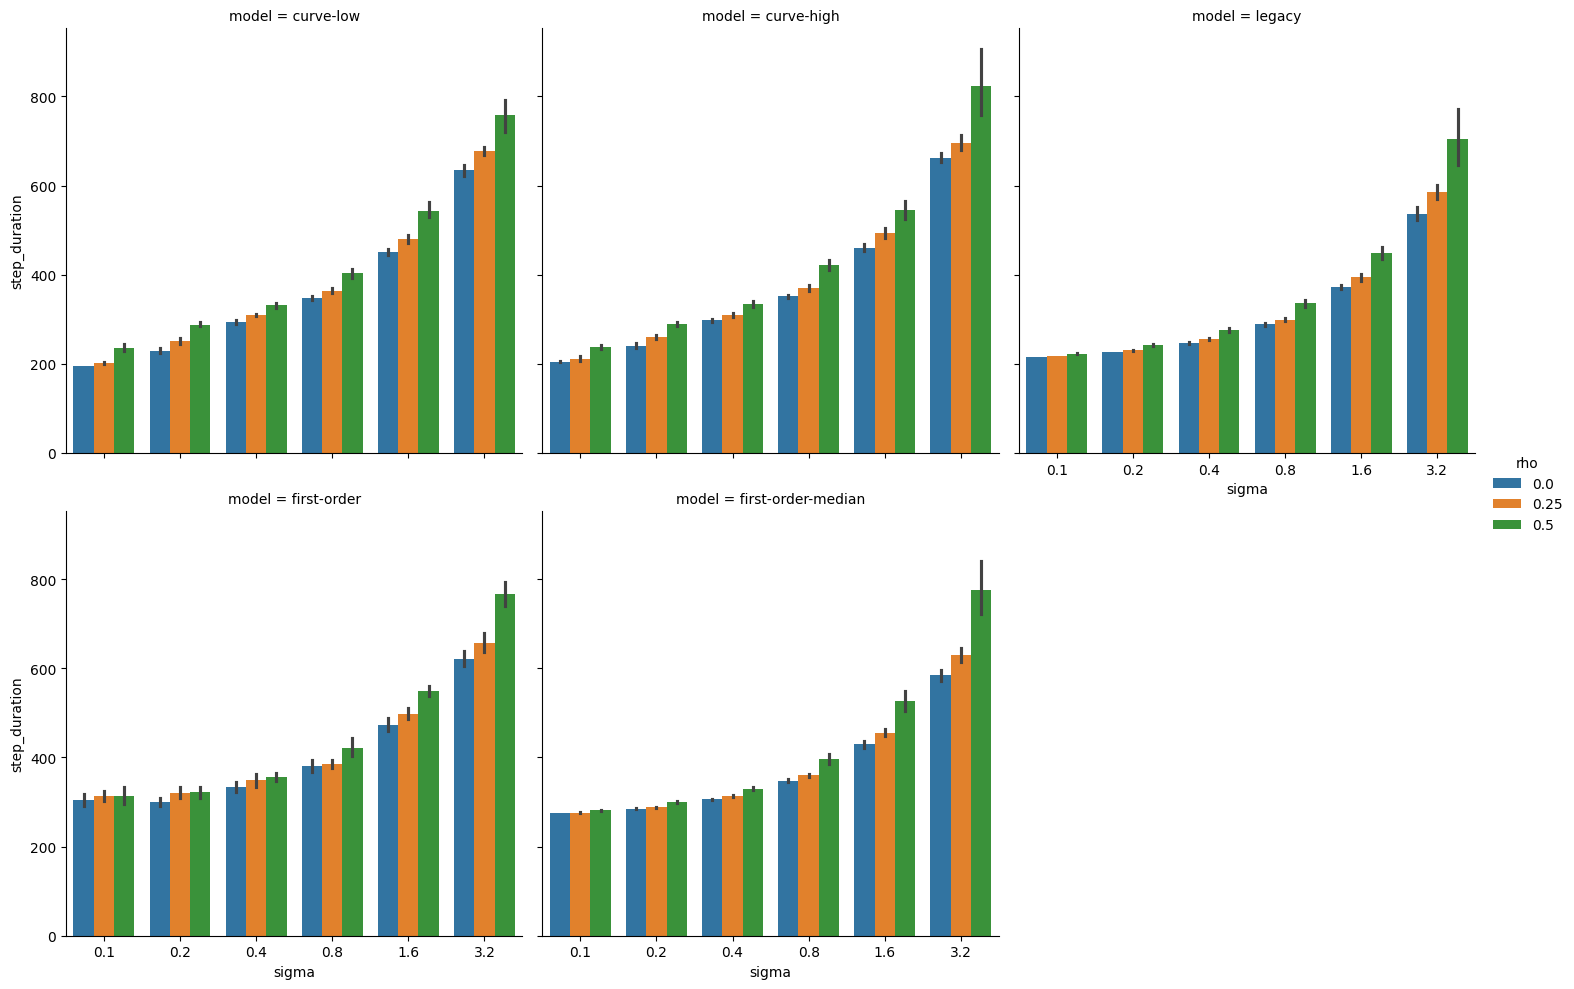

In [49]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

print("mean duration")
fg = sns.catplot(kind="bar", data=total_durations, col="model", hue="rho", y="step_duration", x="sigma", col_wrap=3)
plt.show()

# push correlation higher

mean number of frames


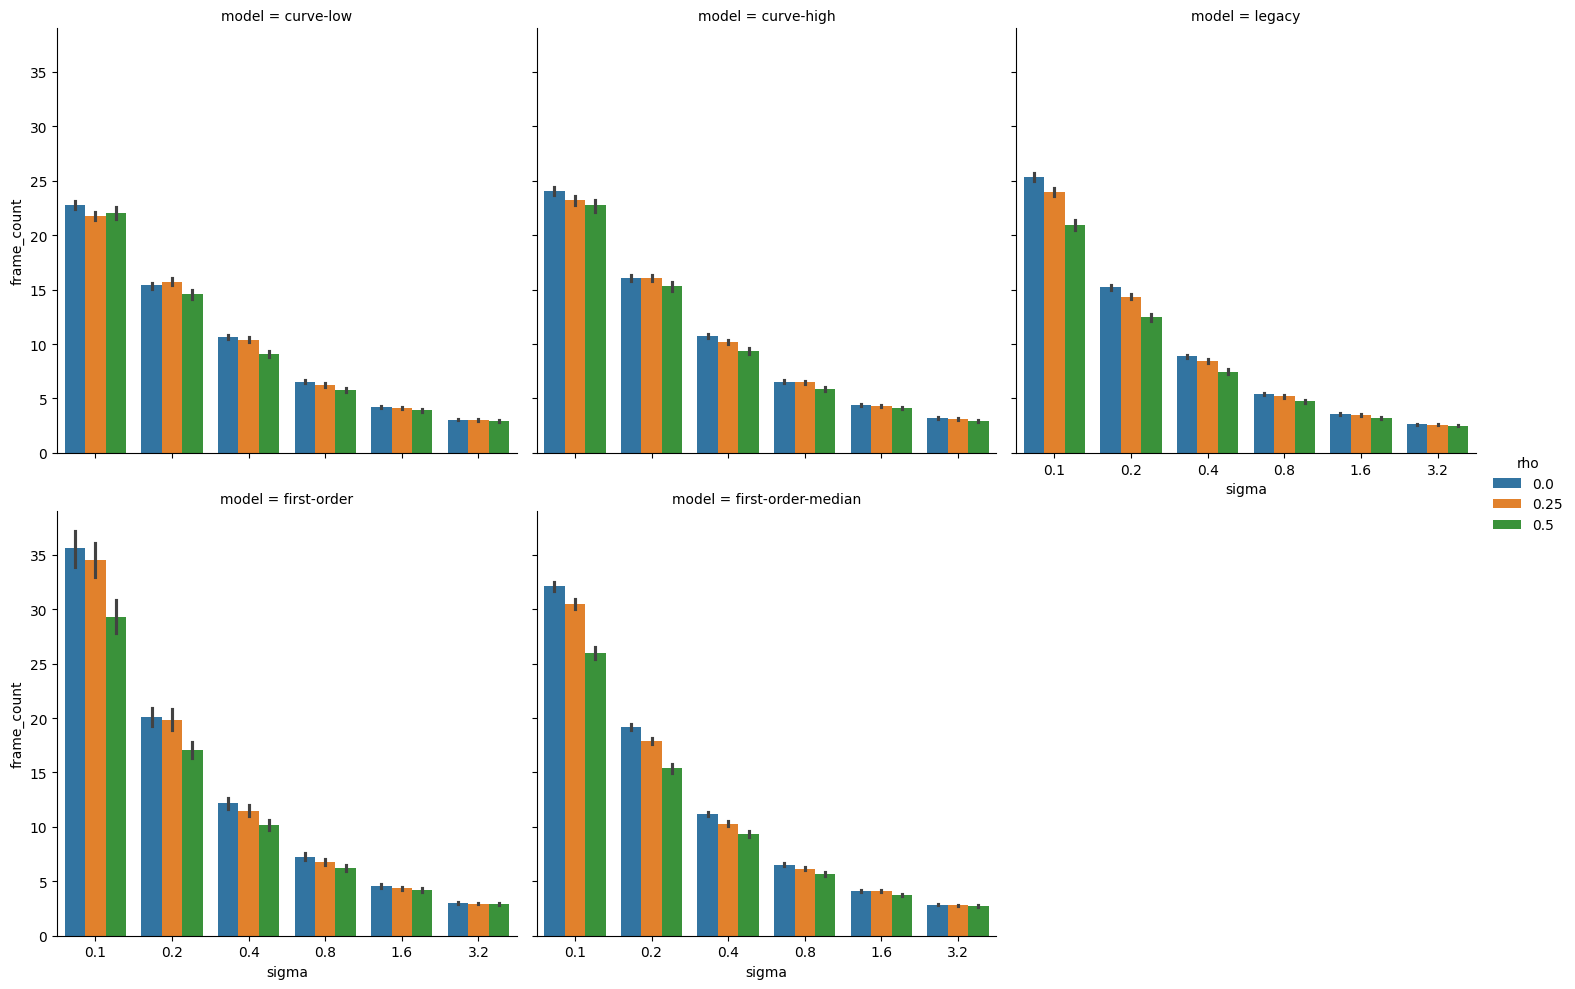

In [50]:
print("mean number of frames")
fg = sns.catplot(kind="bar", data=data, col="model", hue="rho", y="frame_count", x="sigma", col_wrap=3)
plt.show()

mean TTF


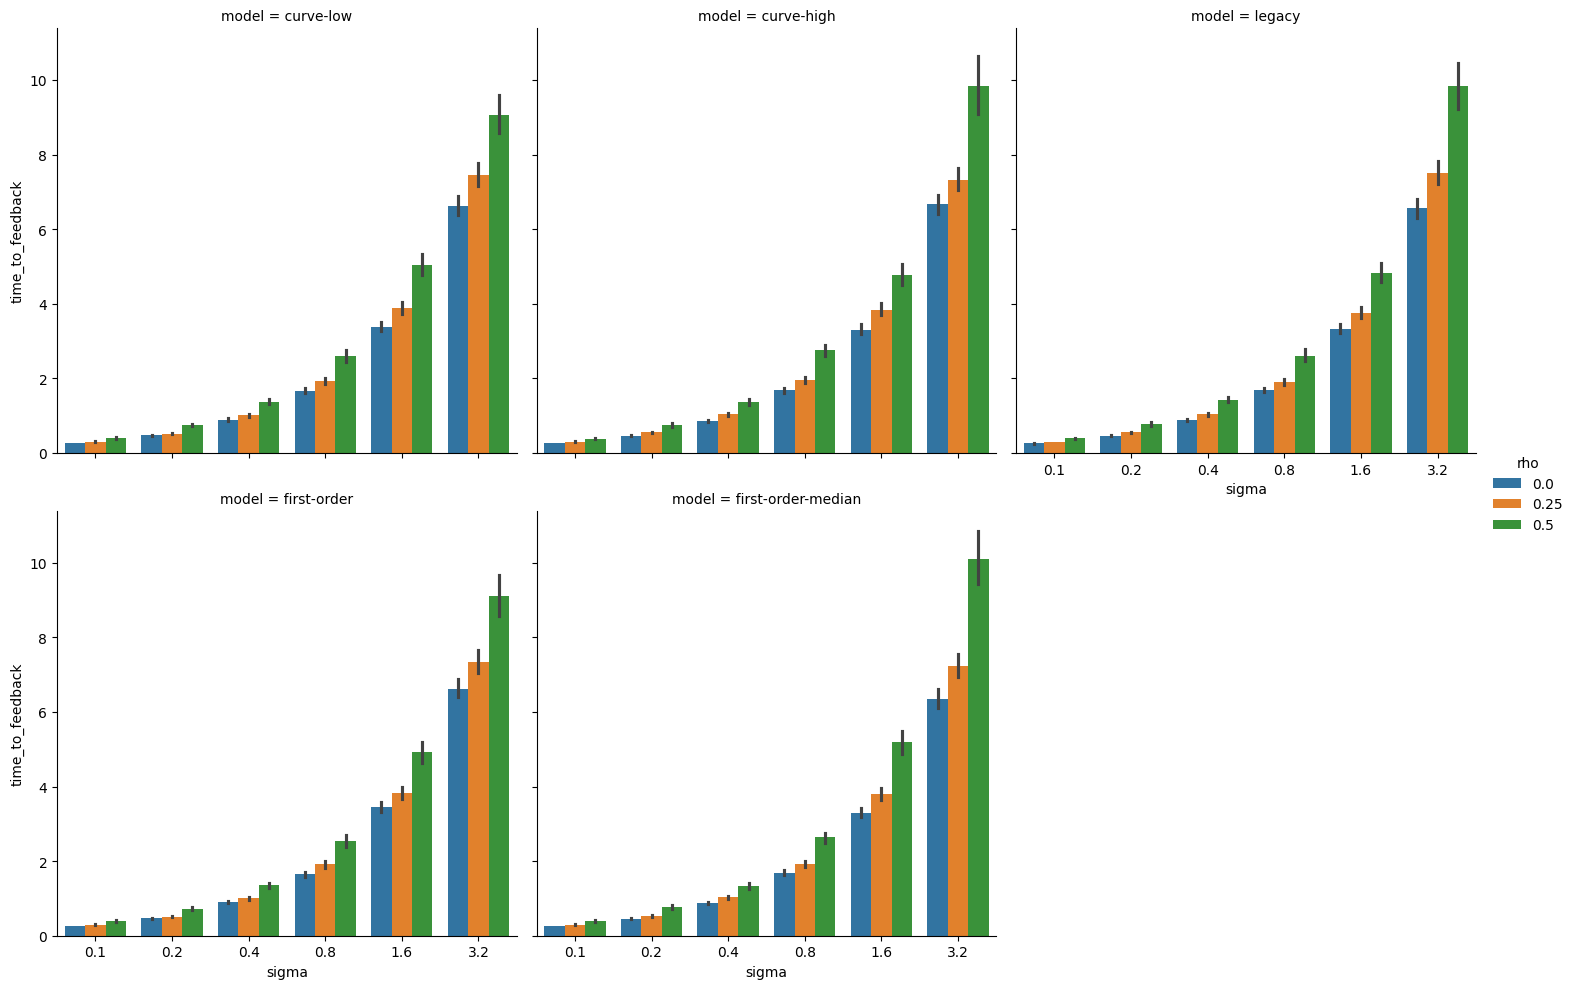

In [51]:
print("mean TTF")
fg = sns.catplot(kind="bar", data=data, col="model", hue="rho", y="time_to_feedback", x="sigma", col_wrap=3)
plt.show()

mean wait time


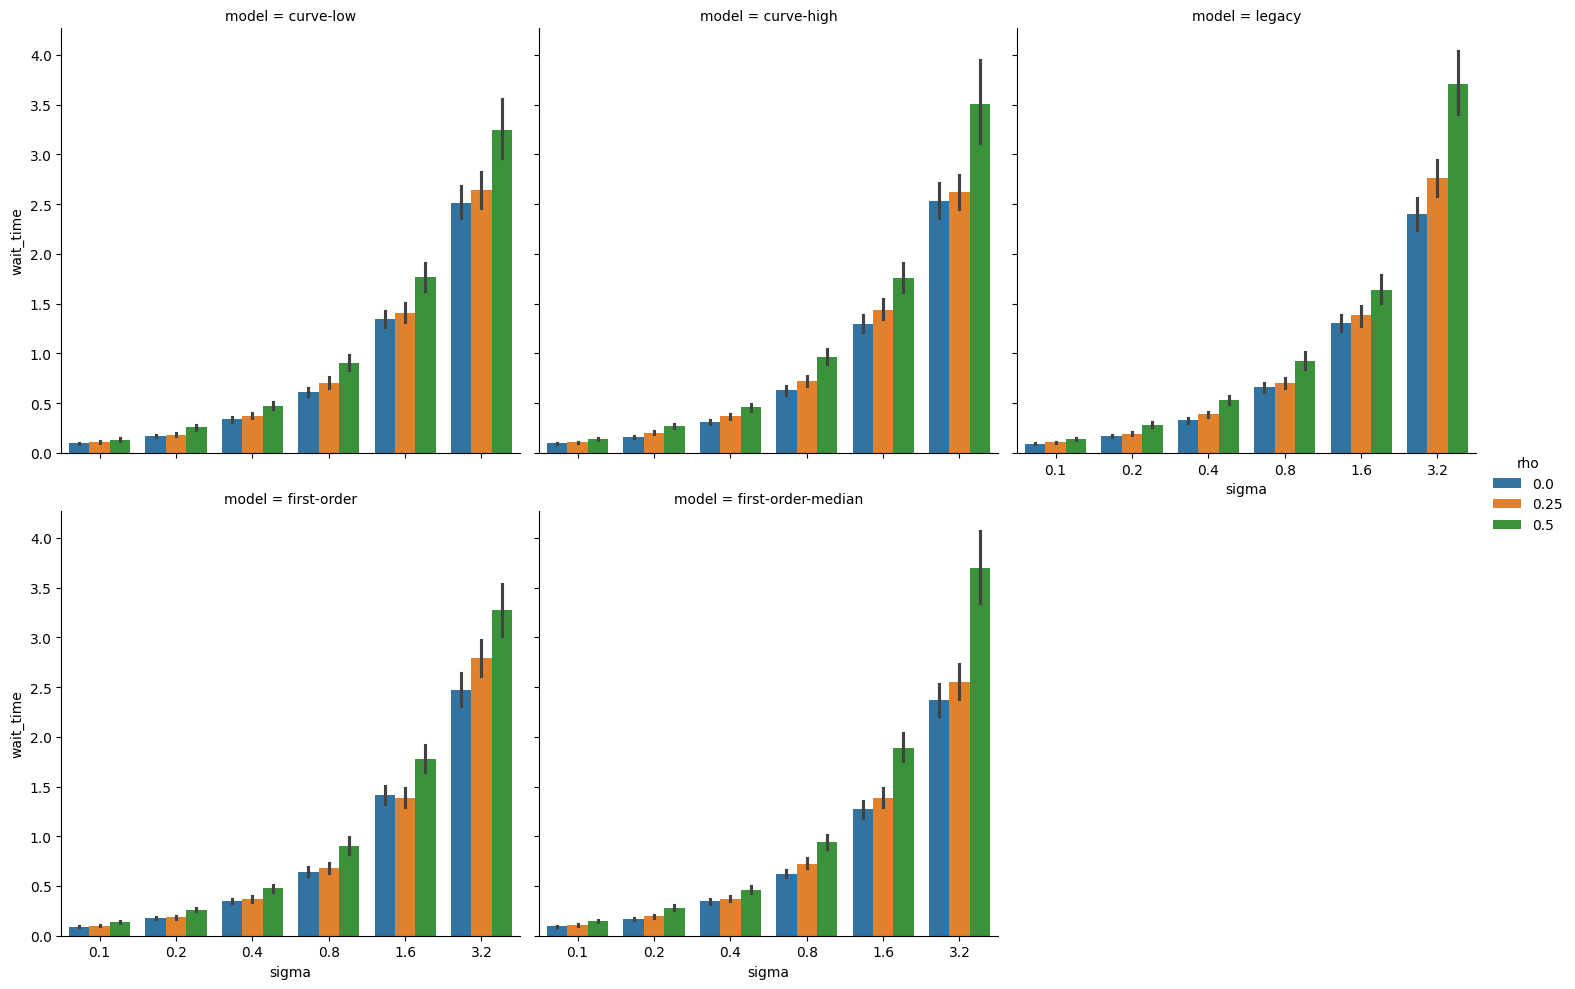

In [52]:
print("mean wait time")
fg = sns.catplot(kind="bar", data=data, col="model", hue="rho", y="wait_time", x="sigma", col_wrap=3)
plt.show()

mean last frame rtt


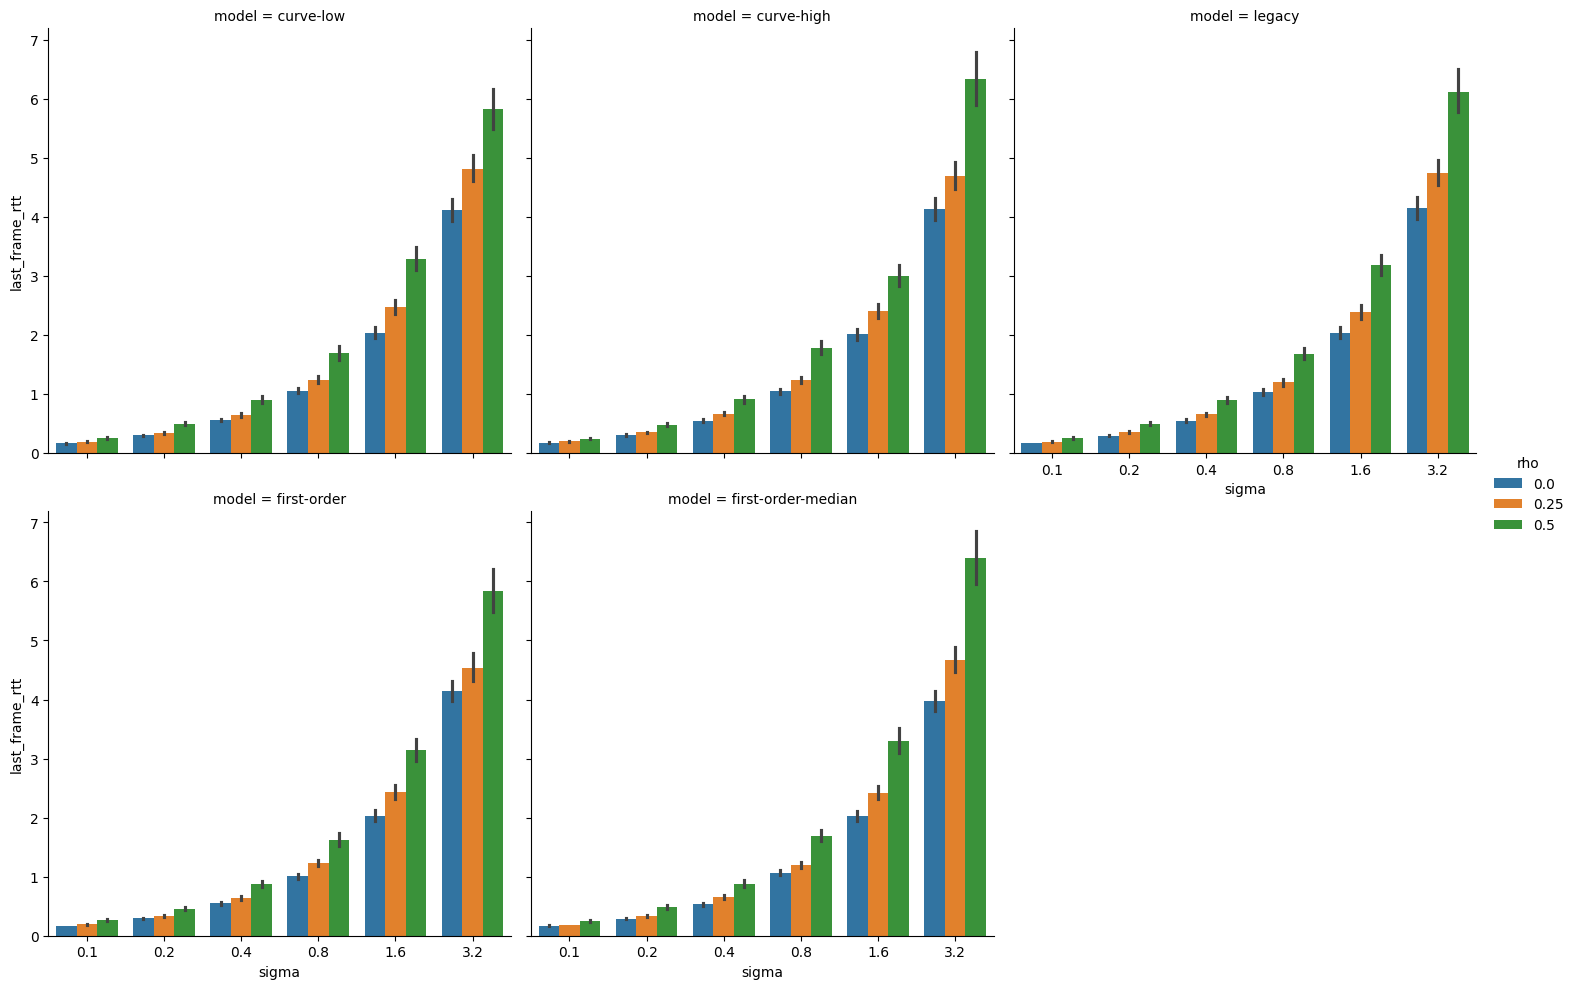

In [53]:
print("mean last frame rtt")
fg = sns.catplot(kind="bar", data=data, col="model", hue="rho", y="last_frame_rtt", x="sigma", col_wrap=3)
plt.show()

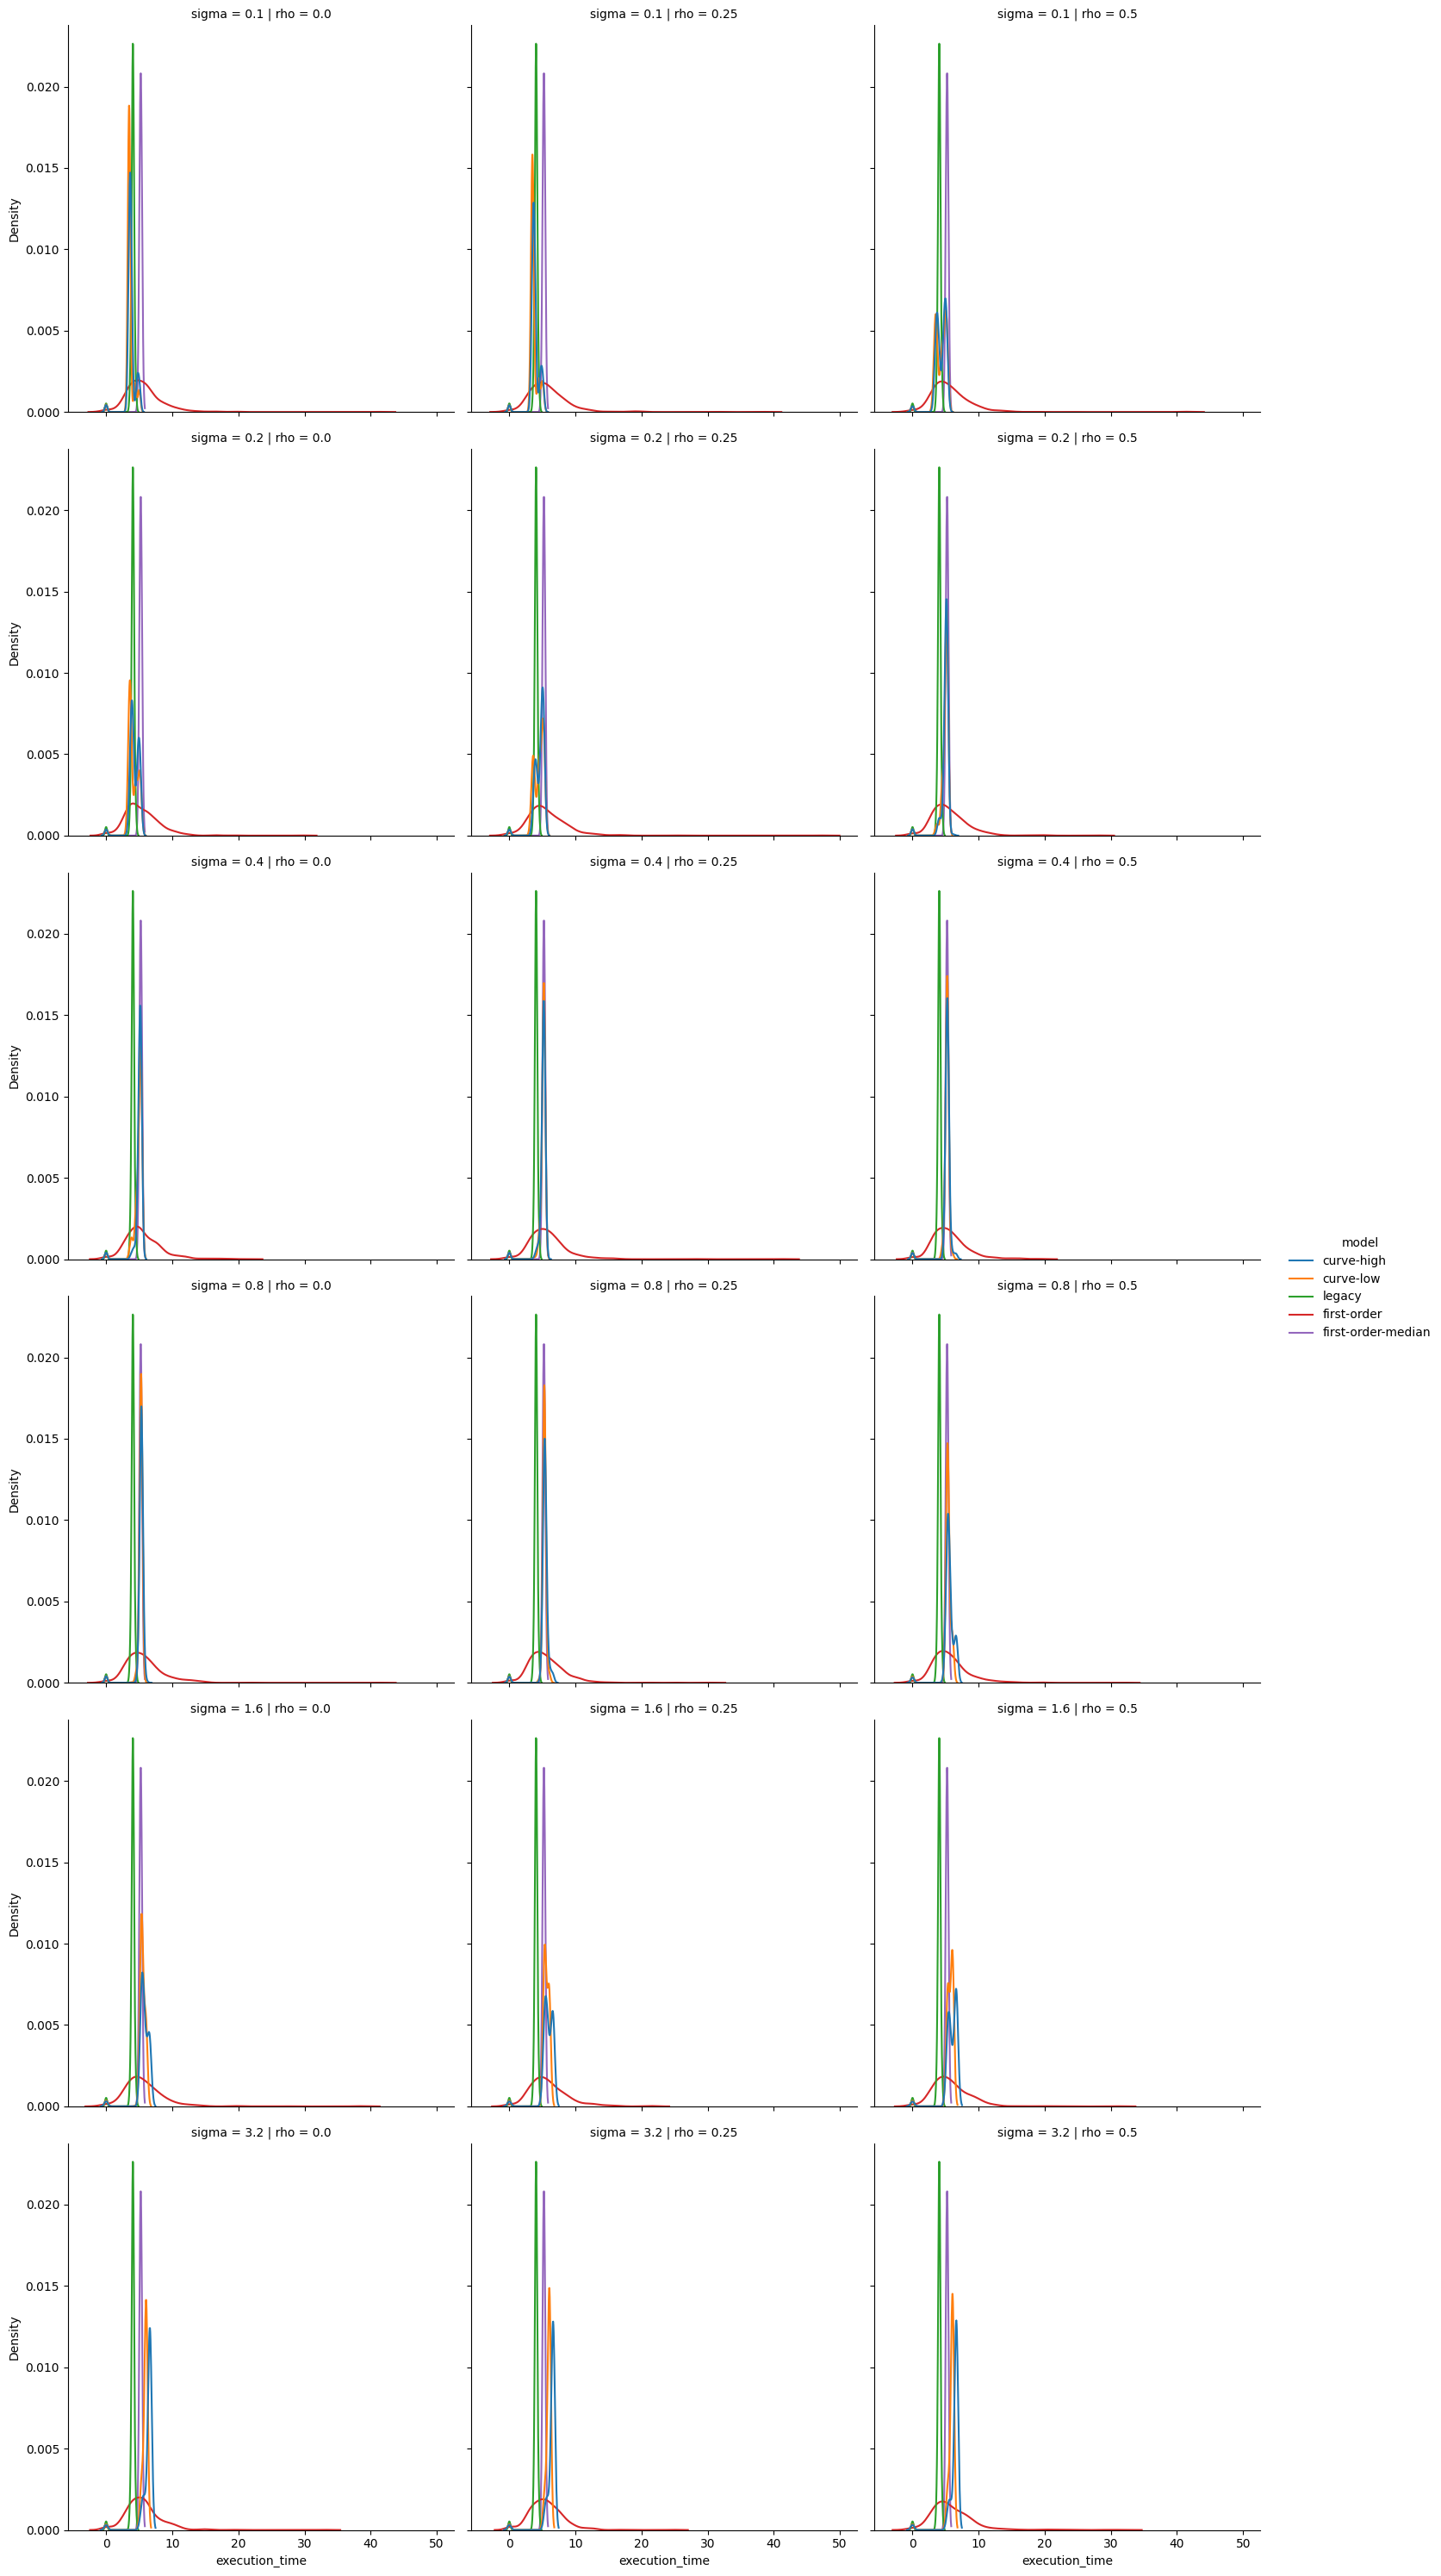

In [31]:
fg = sns.displot(data=data, kind="kde", x="execution_time", hue="model", col="rho", row="sigma" )
plt.show()